In [1]:
from sklearn.cluster import KMeans
import cv2
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import json

import sys
sys.setrecursionlimit(10000)

In [2]:
fpath = 'Dataset/512x/ii'
print(os.getcwd())
try:
  os.chdir(fpath)
except FileNotFoundError:
  pass

with open('label/train.json') as f:
  imgD = json.load(f)

annD = dict()
for i in imgD['annotations']:
    imgN = i['image_id']
    if imgN in annD:
        annD[imgN].append(i)
    else:
        annD[imgN] = [i]

nameD = dict()
for i in imgD['images']:
    imgN = i['id']
    if imgN in nameD:
        nameD[imgN].append(i)
    else:
        nameD[imgN] = [i]

/home/karthik/ml_materials


In [3]:
def kmeans_mask(img, k):
  K = k
  attempts=10
  img_convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img_convert.shape))

  image = result_image.copy()

  n = len(image)
  mx = 0
  for i in range(n):
    for j in range(n):
      mx = max(image[i][j][0], mx)

  for i in range(n):
    for j in range(n):
      if image[i][j][0] != mx:
        image[i][j] = np.array([0, 0, 0])

  return (image, result_image)

In [4]:
def fetch_img(imgNo, base_path='im_train/'):
    img_name = nameD[imgNo][0]['file_name']
    img_path = base_path + img_name
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    segs = [annD[imgNo][i]['segmentation'][0] for i in range(len(annD[imgNo]))]
    # print(segs)
    xs, ys = [], []
    for seg in segs:
        x, y = [seg[i] for i in range(0, len(seg), 2)], [seg[i] for i in range(1, len(seg), 2)]
        xs.append(x)
        ys.append(y)
    # print('X:', xs[:23])
    # print('Y:', ys[:23])
    return (img, (xs, ys))


def draw_ann(img, coords):
    xs, ys = coords
    imgs = [img, img]
    n_row = 1
    n_col = len(imgs)
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    cnt = 0
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
        if cnt % 2:
            for i in range(len(xs)):
                x, y = xs[i], ys[i]
                
                plt.fill(x, y)
        cnt += 1
    plt.show()

In [5]:
def make_bboxes(resimg):
    res = np.array(resimg)
    visited = [[False for _ in range(len(res))] for __ in range(len(res[0]))]

    nums_init = [0, 0, len(res), len(res)] # xmx, ymx, xmn, ymn
    step = 2
    
    bboxes = []
    n = len(res)
    nums = nums_init.copy()
    for i in range(n):
        for j in range(n):
            if res[i][j][0] != 0:
                if not visited[i][j]:
                    dfs(res, i, j, nums, visited, step)
                    bboxes.append(nums)
                    nums = nums_init.copy()
    
    return bboxes
    
def dfs(img, i, j, nums, visited, step):
    visited[i][j] = True
    if img[i][j][0] == 0:
        return
    nums[0], nums[1], nums[2], nums[3] = max(i, nums[0]), max(j, nums[1]), min(i, nums[2]), min(j, nums[3])
    
    steps = list(range(-step, step + 1))
    for x in range(len(steps)):
        for y in range(len(steps)):
            nx, ny = i + steps[x], j + steps[y]
            if not 0 <= nx < len(img) or not 0 <= ny < len(img):
                continue
            if not visited[nx][ny] and img[nx][ny][0] != 0:
                dfs(img, nx, ny, nums, visited, step)

In [6]:
def trim_bboxes(bboxes, sz=100):
    bboxes = [i for i in bboxes if (i[0] - i[2])*(i[1]-i[3]) > sz]
    return bboxes


def plot_bboxes(resimg, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(resimg)
    cols = list('bgrcmyk')
    cnt = 0
    for bbox in bboxes:
        imx, jmx, imn, jmn = bbox
        # plt.plot(jmx, imx, jmn, imn, marker='o', color=cols[cnt % len(cols)])
        rect = patches.Rectangle((jmn, imn), (jmx-jmn), (imx-imn), linewidth=1, edgecolor=cols[cnt % len(cols)], facecolor='none')
        ax.add_patch(rect)
        cnt += 1


    plt.show()

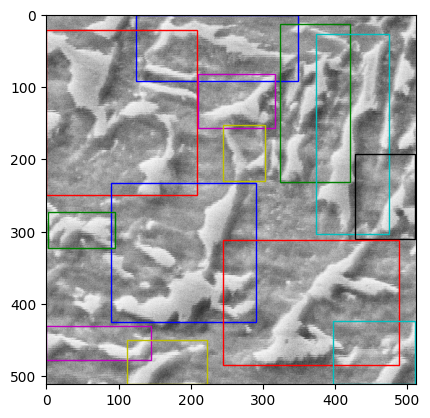

In [7]:
imgNo = 55
ki = 3
img, coords = fetch_img(imgNo)
pimg, _ = kmeans_mask(img, ki)

bbs = make_bboxes(pimg)
bbs = trim_bboxes(bbs, 3000)
plot_bboxes(img, bbs)

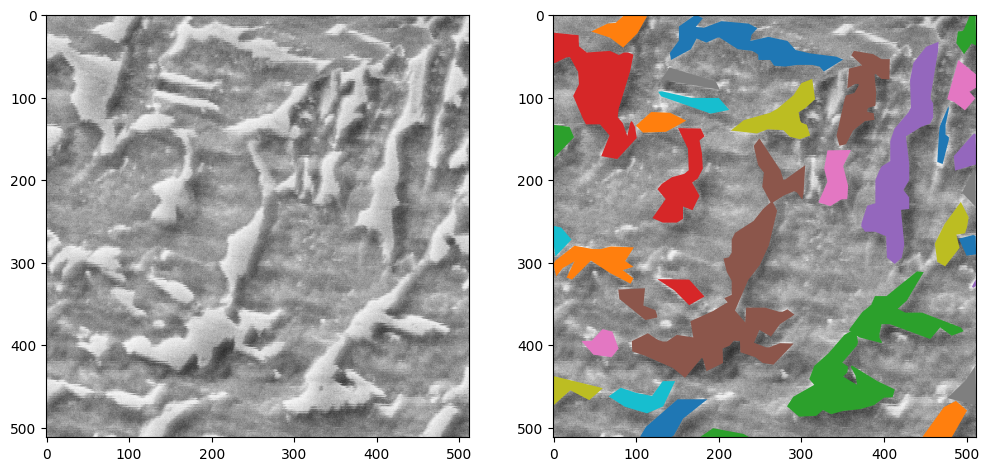

In [8]:
draw_ann(img, coords)

In [9]:
def percent_mask(img):
  n = len(img)
  m = len(img[0])
  cnt = 0
  for i in range(n):
    for j in range(m):
      if img[i][j][0] != 0:
        cnt += 1
  return cnt / (n * m) * 100